**Import modules and set paths.**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json   
import numpy as np
import pandas as pd 
from scipy.sparse import coo_matrix
# from scipy.linalg import lstsq
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from ipywidgets import interact
from threadpoolctl import threadpool_limits

from lininvbox.lininvbox.equation import Term
from lininvbox.lininvbox.constructors import *
from lininvbox.lininvbox.operations import *
from lininvbox.lininvbox.inversion import Inversion
from lininvbox.lininvbox.constraints import *
from lininvbox.lininvbox.regularisation import *
from lininvbox.lininvbox.utils import delete_directory

from mlinversion.mlinversion.regtests import *
from magscales.magscales import Richter1958
from plotconf import matsettings


using numpy v1.21.0.
using pandas v1.3.0.


## Yellowstone National Park $M_L$ Non-Paramatric Inversion
### A notebook to perform a non-parametric inversion to recover $M_L$, distance and station corrections using earthquakes from Yellowstone Nation Park.



In [2]:
PDIR = ".."
for_inv = pd.read_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.geobalanced.csv")
sims = pd.read_csv(f"{PDIR}/miscmeta/simulations/data/sim_out.csv")

In [3]:
interp_nodes = np.array([1, 10, 30, 50, 100, 180])
inc = np.geomspace(4, 180, 20)
dr = 5
inc = np.arange(20, 180+dr, dr)
interp_nodes = np.round(np.append([3,6,9,12,15,18,21], inc[inc>=25]), 1)
# interp_nodes=inc
interp_values = np.sort(for_inv.Rhyp.values)

mwcat = pd.read_csv("../catalogs/events/MTCAT.csv")
mwcat["Evid"] = mwcat["Evid"].astype(str)
MLcons = dict(mwcat[["Evid", "UUSSMw"]].dropna().values)


In [4]:
def vis_inv_output(inv):

    terms = inv.m.term_map.values.keys()
    X, Y = [],[]
    for term in terms:
        tmp = inv.m.term_map.get_term(term)
        if term == "MLi":
            X.append(tmp['unique_indices'])
        else:
            X.append(tmp['unique_labels'])
        Y.append(tmp['model_values'])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, y, x, term, x_lab in zip(axes, Y, X, terms, ["Rhyp [km]", "Ev #", "Sj"]):
        ax.plot(x, y, 'ks', mfc='none')
        ax.set_ylabel(term)
        ax.set_xlabel(x_lab)
        if term == "Sj":
            ax.tick_params(axis='x', labelrotation = 90)
            
    return fig, axes

def vis_matrices(mats, kind='spy', **kwargs):

    fs = (4.5*2, 15)
    
    if type(mats) is list:
        assert type(mats[0]) is coo_matrix or type(mats[0]) is np.ndarray,\
        f"Matrices in list must be coo_matrix or np.ndarray not {type(mats[0])}."

        fig, axes = plt.subplots(1, num_mats, figsize=fs)
    else:
        fig, axes = plt.subplots(1, 1, figsize=fs)
        axes = [axes,]
        mats = [mats,]

    for mat, ax in zip(mats, axes):

        # spy plot
        if kind == 'spy':
            ax.spy(mat, aspect='auto', **kwargs)
        # matshot
        if kind == 'matshow':
            a = ax.matshow(mat.toarray(), aspect='auto', **kwargs)
            fig.colorbar(a)

    fig.tight_layout()
    
    return fig, axes



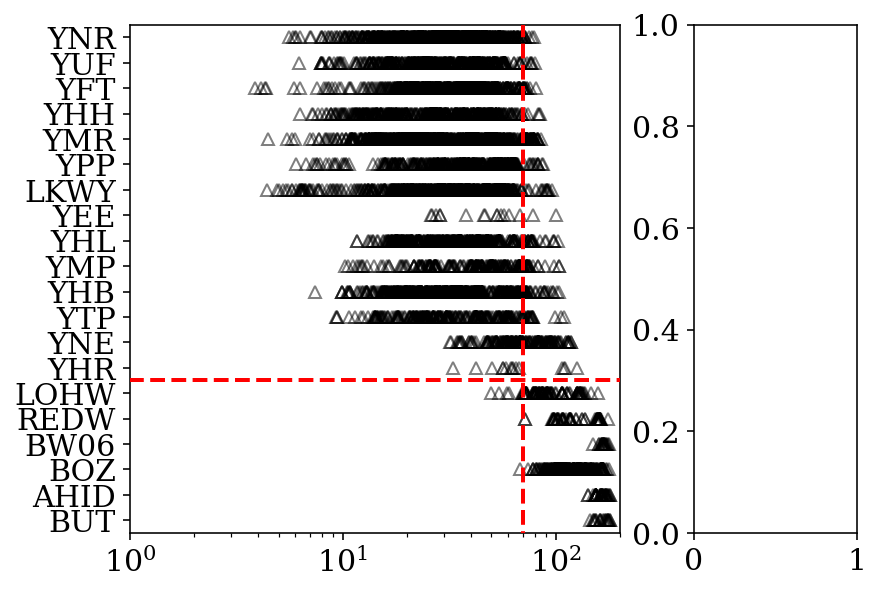

In [39]:
sta_df = for_inv.copy(deep=True).sort_values(["Rhyp", "Sta"], ascending = False)

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=4, nrows=1) 
ax1 = fig.add_subplot(gs[0, :-1])
ax1.vlines(70, -1, 20, color='red', linestyles='dashed', linewidth=2, zorder=10)
ax1.hlines(5.5, 0.1, 210, color='red', linestyles='dashed', linewidth=2, zorder=10)
ax1.semilogx(sta_df["Rhyp"], sta_df["Sta"], '^', color='k', mfc='none', alpha=0.5)
ax1.set(ylim=[-0.5, 19.5], xlim=[1, 200])

ax2 = fig.add_subplot(gs[0, -1])
# fig.tight_layout()

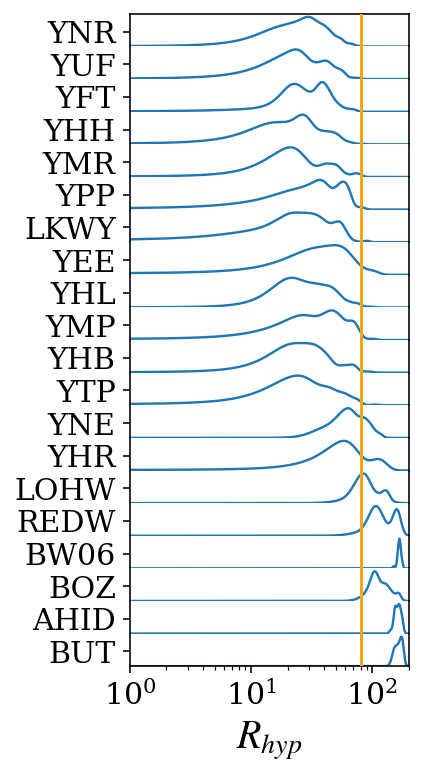

In [142]:
import scipy.stats


stas = list(sta_df.groupby("Sta")["Rhyp"].max().sort_values().index)
stas_min = dict(sta_df.groupby("Sta")["Rhyp"].min())
stas_max = dict(sta_df.groupby("Sta")["Rhyp"].max())
fig, axes = plt.subplots(len(stas), 1, figsize=(2.5, 6), sharex=True)

for i, sta in enumerate(stas):

    density = scipy.stats.gaussian_kde(sta_df[sta_df["Sta"]==sta]["Rhyp"])
    # d = np.geomspace(stas_min[sta]*0.5, stas_max[sta]*1.1, 50)
    d = np.arange(1, 201,)
    pdf = density.pdf(d)
    axes[i].semilogx(d, pdf, '-', lw=1.2)
    axes[i].set(
        yticks = [pdf.max() / 2, ], 
        yticklabels = [sta, ],
        ylim = [pdf.min()*0.9, pdf.max()*1.1],
        xlim = [1, 200]
        )
    axes[i].vlines(80, -1, 1, color='orange', linewidth=1.5, zorder=10)

for j, ax in enumerate(fig.get_axes()):
    ss = ax.get_subplotspec()
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.xaxis.set_visible(ss.is_last_row())
    if ss.is_last_row():
        ax.set_xlabel(r"$R_{hyp}$")
fig.subplots_adjust(hspace=0)

fig.savefig("../figures/STATION-DIST-KDEs.pdf", bbox_inches="tight")

{'AHID': 141.93988164,
 'BOZ': 68.2529039675,
 'BUT': 144.928212919,
 'BW06': 150.37319043,
 'LKWY': 4.39591856158,
 'LOHW': 49.6059159778,
 'REDW': 71.8594906745,
 'YEE': 25.9290358479,
 'YFT': 3.87258311725,
 'YHB': 7.39762799822,
 'YHH': 6.30752724925,
 'YHL': 11.6329231064,
 'YHR': 32.9655638508,
 'YMP': 10.3020823138,
 'YMR': 4.47320913886,
 'YNE': 31.818518193,
 'YNR': 5.57943545531,
 'YPP': 6.02162768693,
 'YTP': 9.2756077968,
 'YUF': 6.25159979525}

In [5]:
stas = for_inv[["Net", "Sta"]].agg('.'.join, axis=1).values
evs = for_inv['Evid'].apply(str).values

In [6]:
logA0np = Term("logA0n", "LINEAR INTERPOLATION", for_inv.Rhyp.values, unique_labels=interp_nodes)
MLp = Term("MLi", "CONSTANT", evs)
Sjp = Term("Sj", "CONSTANT", stas, sign=-1)

In [7]:
logA0n = LinInterpCoeffs(logA0np) 
MLi = ConstantCoeffs(MLp)
Sj = ConstantCoeffs(Sjp)
G = logA0n + MLi + Sj
d = DataArray(for_inv['halfAmpH'].apply(np.log10))

In [8]:
inv = Inversion("YPML")

In [9]:
inv.invert(G, d)

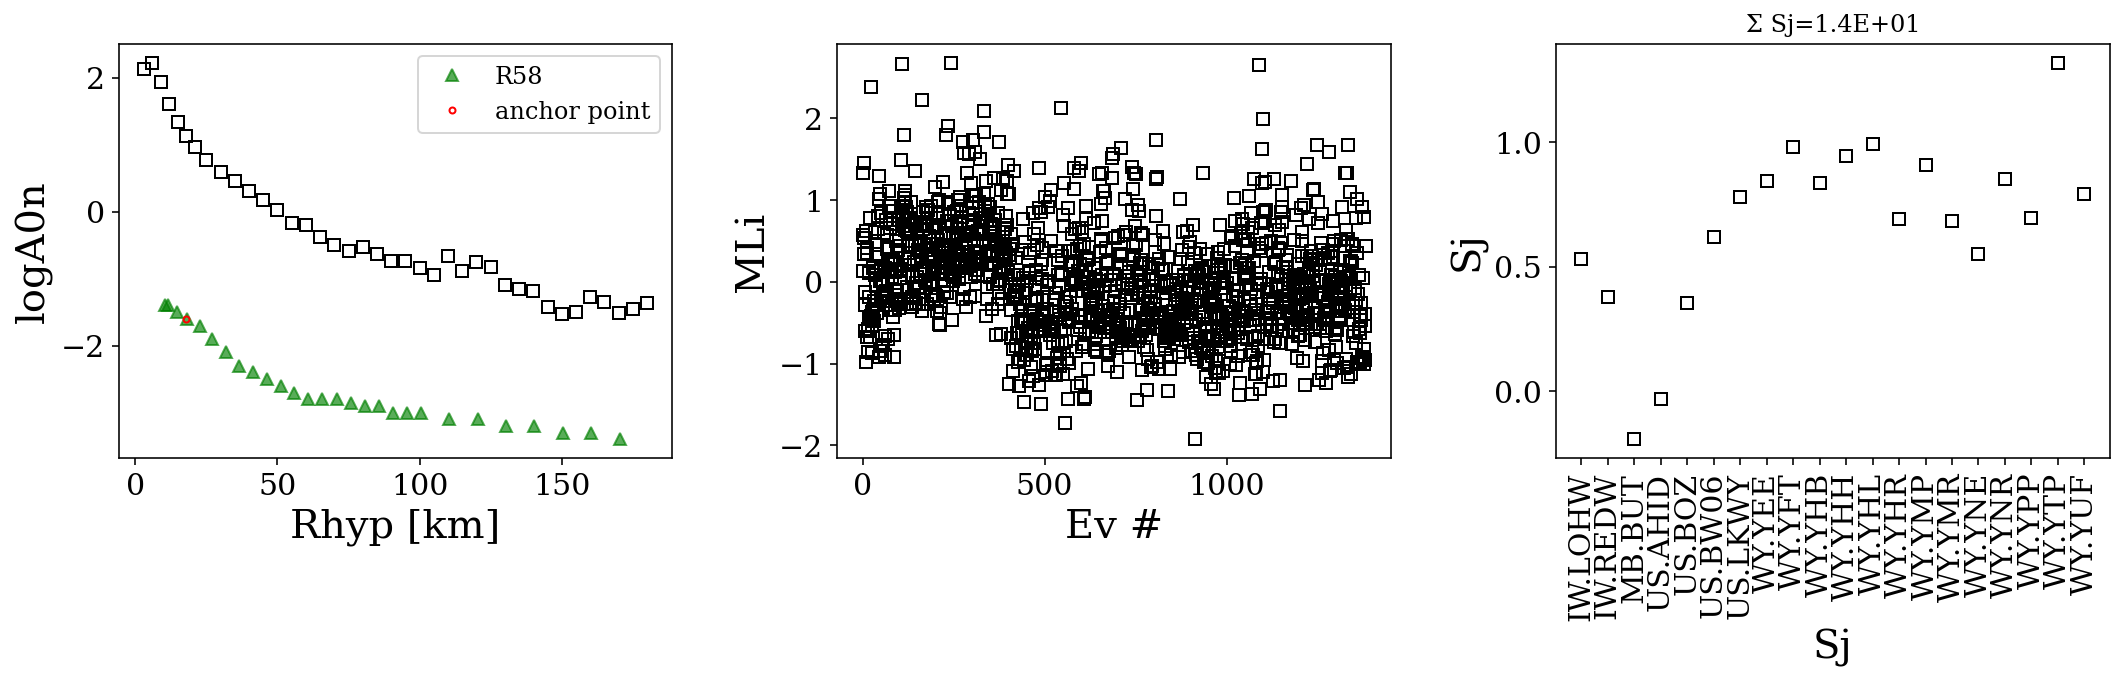

In [10]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()
# axes[0].set_xscale("log")

## Smoothing parameter ($\alpha$) penalty tests

To smooth our inversions we use the Thikonov formality ()

### Roughness vs MSE
In the first set of tests we show the roughness ($||\dfrac{\mathrm{d^2}logA_{0}(R)}{\mathrm{d}R^2}||^2$) by the mean error  of the resdiuals between predicted and recorded data (MSE). 

In [11]:
# def reg_test_invert(inv, G, d, alpha, constraints):
#     """

#     """
#     Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alpha)))

#     m = inv.invert(G, d, regularisation=Gamma, constraints=constraints, inplace=False)
#     fd = inv.forward(G, m)
#     _mse = mse(d.array.A.flatten(), fd.array.A.flatten())
#     inds = m.term_map.values["logA0n"]['model_indices']
#     _rough = roughness(m.array.A[inds].flatten())

#     return _mse, _rough



# def regularisation_optimiser(inv, G, d, alphas, constraints=None):
#     """

#     """
#     _rough = np.zeros(len(alphas))
#     _mse = np.zeros(len(alphas))

#     with threadpool_limits(limits=2, user_api='blas'):
#         for i in range(len(alphas)):
#             MSE, ROUGH = reg_test_invert(inv, G, d, alphas[i], constraints)
#             _mse[i] = MSE
#             _rough[i] = ROUGH

#     # obtain turning point of "L-curve" (minimum in this case) ...
#     # and take that as the optimal value for alpha.
#     # + 2 because you lose two points by differentiating twice from the ...
#     # finite difference approximations
#     pt = np.abs(np.diff(np.log10(_rough), 2)).argmin() + 2

#     return _mse, _rough, pt


# def do_norm_test(inv, alphas, root="../mlinversion/.norm"):
#     try:
#         a_comp = np.load(f"{root}/alphas.npy")
#         if not np.array_equal(a_comp, alphas):
#             print("new alphas detected...")
#             delete_directory(f"{root}/")
#         else:
#             print("alphas unchanged...")
#         _mse = np.load(f"{root}/mse.npy")
#         _rough = np.load(f"{root}/rough.npy")
#         best_i = np.load(f"{root}/besti.npy")
#         print("loaded local files...")

#     except FileNotFoundError:
#         print("running inversions...")
#         _mse, _rough, best_i = regularisation_optimiser(inv, G, d, alphas)
#         os.makedirs(f"{root}/", exist_ok=True)
#         np.save(f"{root}/mse.npy", _mse)
#         np.save(f"{root}/rough.npy", _rough)
#         np.save(f"{root}/besti.npy", best_i)
#         np.save(f"{root}/alphas.npy", alphas)
#     print(f"Best alpha is {alphas[best_i]:.2f}.")

#     return _mse, _rough, best_i

inv = Inversion("YPML")
alphas = np.round(np.geomspace(1E-1, 500, 50), 3)
_mse, _rough, best_i = do_norm_test(inv, G, d, alphas)


alphas unchanged...
loaded local files...
Best alpha is 87.92.


In [12]:
best_i = np.abs((alphas-22.8)).argmin()
best_i

31

We obtain an "L-curve" and choose the value for alpha at the point of maximum curvature (2nd derivative is minimum).

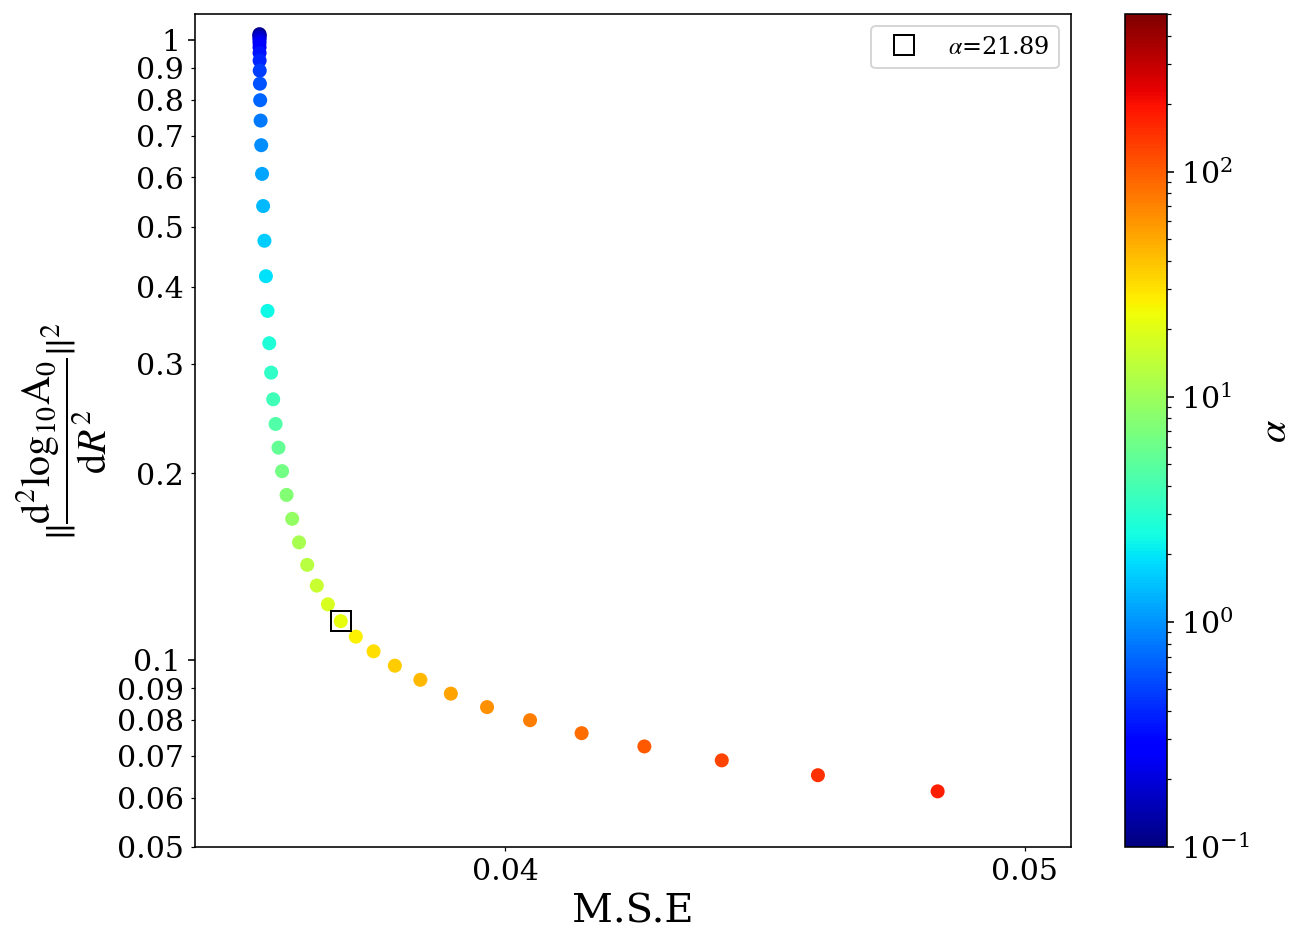

In [13]:
def plot_regularisation_optimiser(mse, rough, alphas, best_i, save=""):
    fac = 1.25
    fig, ax = plt.subplots(1,1, figsize=(7.5*fac, 5.5*fac))
    out = ax.scatter(mse, rough, c=alphas, cmap="jet", norm=matplotlib.cm.colors.LogNorm()) 
    ax.loglog(mse[best_i], rough[best_i], 'ks', ms=10, mfc='none', label=r"$\alpha$={:.2f}".format(alphas[best_i]))
    ax.set_xlabel("M.S.E")
    ax.set_ylabel(r"$||\dfrac{\mathrm{d^2log_{10}A_{0}}}{\mathrm{d}R^2}||^2$") 
    ax.legend()
    fig.tight_layout()
    fig.colorbar(out, label=r"$\alpha$")
    ax.set_ylim([0.05, 1.1])
    ax.set_xlim([0.035, 0.051])
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    if save:
        fig.savefig(save)
        
plot_regularisation_optimiser(_mse, _rough, alphas, best_i, "../figures/NORM.pdf")

Visulise the effect on changing $\alpha$ on the recovered model.

In [14]:
C =  Constraints(G.term_map, OrderedDict(Sj={"SUM":0},))
              
@interact
def alpha_vis(alpha=np.round([1E-1, 3, 5, 7.38, 10, 20], 2)):
    
    global C
    plt.close()
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alpha)))
    inv = Inversion("YPML")
    inv.invert(G, d, constraints=C, regularisation=Gamma)

    r = Richter1958()
    r.epi_to_hypo(av_dep=10.5)
    fig, axes = vis_inv_output(inv)
    axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
    axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
    axes[0].legend()
    axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='alpha', options=(0.1, 3.0, 5.0, 7.38, 10.0, 20.0), value=0.1), Out…

### Station-amplitude-distance distributions

Can we speculate which stations we might expect a significant bias by looking at the KDE's of the distance distributions?

interactive(children=(Dropdown(description='station', options=('AHID', 'LKWY', 'BUT', 'YMR', 'BOZ', 'YFT', 'BW…

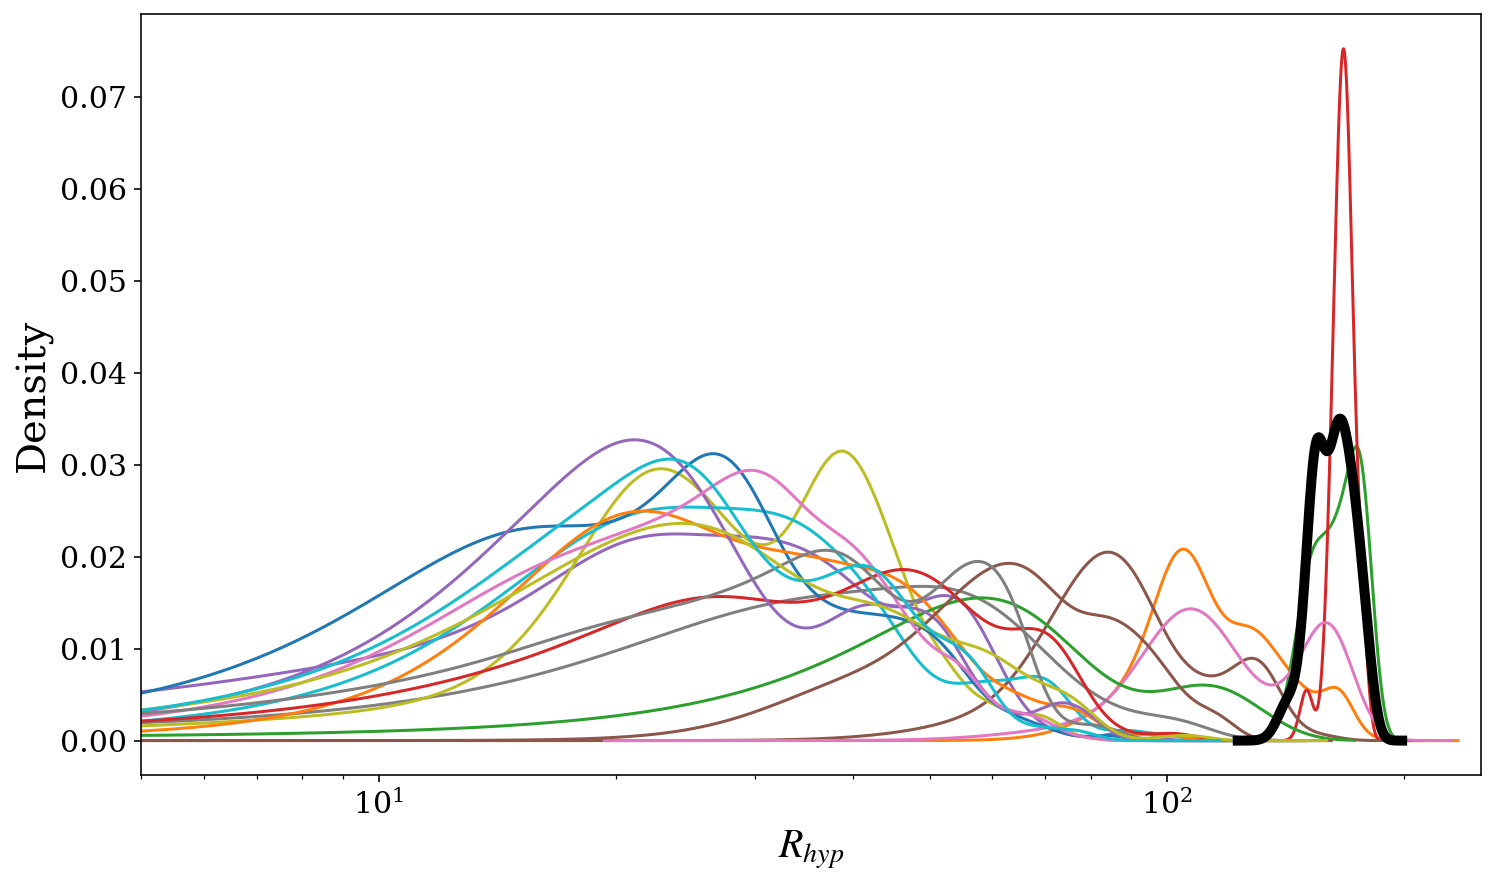

In [15]:
@interact
def plot_sta_kdes(station=for_inv.Sta.unique(), dist_metric=["Rhyp", "Repi"]):
    plt.figure(figsize=(12, 7))
    out = for_inv.groupby("Sta")[dist_metric].plot.kde(logx=True)
    plt.xlim([5, 250])
    plt.xlabel(r"${}$".format(f"{dist_metric[0]}_{'{'}{dist_metric[1:]}{'}'}"))
    for_inv[for_inv.Sta.isin([station,])].groupby("Sta")[dist_metric].plot.kde(color='k', lw=5)


Visualise the effect of arbitrary constraints on the recovered model.

In [16]:
c1 = OrderedDict(#logA0n={18:-1.6}, 
                   Sj={"SUM":0},)
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
#                    MLi=MLcons)
c2 = OrderedDict(logA0n={18:-1.6}, 
                   Sj={"SUM":0},)
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
#                    MLi=MLcons)

c3 = OrderedDict(#logA0n={18:-1.6}, 
                   Sj={"SUM":0},
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
                   MLi=MLcons)

c4 = OrderedDict(Sj={"SUM":0},
#                    Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
                   MLi=MLcons)

c5 = OrderedDict(logA0n={18:-1.6}, 
#                    Sj={"SUM":0},
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43,
                       "US.BOZ":0.17, "US.BW06":-0.15},)
#                    MLi=MLcons)

c6 = OrderedDict(logA0n={18:-1.6}, 
#                    Sj={"SUM":0},
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43,
                       "US.BOZ":0.17, "US.BW06":-0.15},
                   MLi=MLcons)

c7 = OrderedDict(#logA0n={18:-1.6}, 
#                    Sj={"SUM":0},)
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43, 
                       "US.BOZ":0.17, "US.BW06":-0.15},
                   MLi=MLcons)

c8 = OrderedDict(#logA0n={18:-1.6}, 
#                    Sj={"SUM":0},)
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43, 
                       "US.BOZ":0.17, "US.BW06":-0.15},)
#                    MLi=MLcons)

cons = [c1, c2, c3, c4, c5, c6, c7, c8]
Cs = [None]+[Constraints(G.term_map, constraints=con) for con in cons]

@interact
def constraints_vis(C=Cs, A=-np.round(np.arange(0.3, 1.1, 0.1), 1)):

    plt.close()
    inv = Inversion("YPML")
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alphas[best_i])))
    inv.invert(G, d, regularisation=Gamma, constraints=C)

    r = Richter1958()
    r.epi_to_hypo(av_dep=10.5)
    fig, axes = vis_inv_output(inv)
    axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
    axes[0].hist2d(sims.rhyp, sims.A+A, bins=(30,25), cmap="gnuplot", norm=matplotlib.cm.colors.LogNorm(),)
    axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
    axes[0].legend()
    axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
    axes[2].plot(["MB.BUT", "US.AHID", "US.BOZ", "US.BW06"], [-0.23, -0.43, 0.17, -0.15], 'ro', label='UUSS')
    axes[2].legend()
    fig.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='C', options=(None, Fixed... Sj SUM Sj, Fixed... logA0nSj SUM Sj, F…

### Save the chosen model

In [17]:
logA0np = Term("logA0n", "LINEAR INTERPOLATION", for_inv.Rhyp.values, unique_labels=interp_nodes)
MLp = Term("MLi", "CONSTANT", evs)
Sjp = Term("Sj", "CONSTANT", stas, sign=-1)
logA0n = LinInterpCoeffs(logA0np) 
MLi = ConstantCoeffs(MLp)
Sj = ConstantCoeffs(Sjp)
G = logA0n + MLi + Sj
d = DataArray(for_inv['halfAmpH'].apply(np.log10))
C = Constraints(G.term_map, constraints=c4)
inv = Inversion("YPML")
Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alphas[best_i])))
inv.invert(G, d, regularisation=Gamma, constraints=C)

In [22]:
def build_name(t_m):
    name = []
    for term, out in t_m.items():
        for k, v in out.items():
            if k.lower() == 'constraints':
                if v:
                    name.append(term)
                    name.append(str(len(v)))
    return "model-" + "-".join(name)

root = "../mlinversion/.model/"
t_m = inv.m.term_map.values
os.makedirs(f"{root}", exist_ok=True)
fname = os.path.join(root, f"{inv.name}-{build_name(t_m)}.json")
print(f"saved {fname}")
pd.DataFrame(t_m).to_json(fname)

saved ../mlinversion/.model/YPML-model-MLi-4-Sj-1.json


In [19]:
logA0 = inv.G.term_map.get_term("logA0n")['model_values'] 
R = inv.G.term_map.get_term("logA0n")['unique_labels']

sj = {
    n: v for n, v in zip(
        inv.G.term_map.get_term("Sj")['unique_labels'], 
        inv.G.term_map.get_term("Sj")['model_values']
    )
}

In [20]:
mws = np.array(list(inv.G.term_map.get_term("MLi")["constraints"].values()), dtype=float)
evids = np.array(list(inv.G.term_map.get_term("MLi")["constraints"].keys()), dtype=int)

As=[];Rhyps=[];Stas=[];
for evid in evids:
    As.append(for_inv[for_inv.Evid==evid][["halfAmpH", "Rhyp"]].sort_values("Rhyp")["halfAmpH"].values)
    Rhyps.append(for_inv[for_inv.Evid==evid][["halfAmpH", "Rhyp"]].sort_values("Rhyp")["Rhyp"].values)
    Stas.append((for_inv[for_inv.Evid==evid][["Net", "Rhyp"]].sort_values("Rhyp")["Net"] + "." + for_inv[for_inv.Evid==evid][["Sta", "Rhyp"]].sort_values("Rhyp")["Sta"]).values)

# warning, the sub-arrays have different lengths
As = np.array(As, dtype='object')
Rhyps = np.array(Rhyps, dtype='object')
Stas = np.array(Stas, dtype='object')
Stacs = np.array([np.vectorize(sj.get)(Sta) for Sta in Stas], dtype='object')
logA0s = np.array([np.interp(Rhyp, R, logA0) for Rhyp in Rhyps], dtype='object')

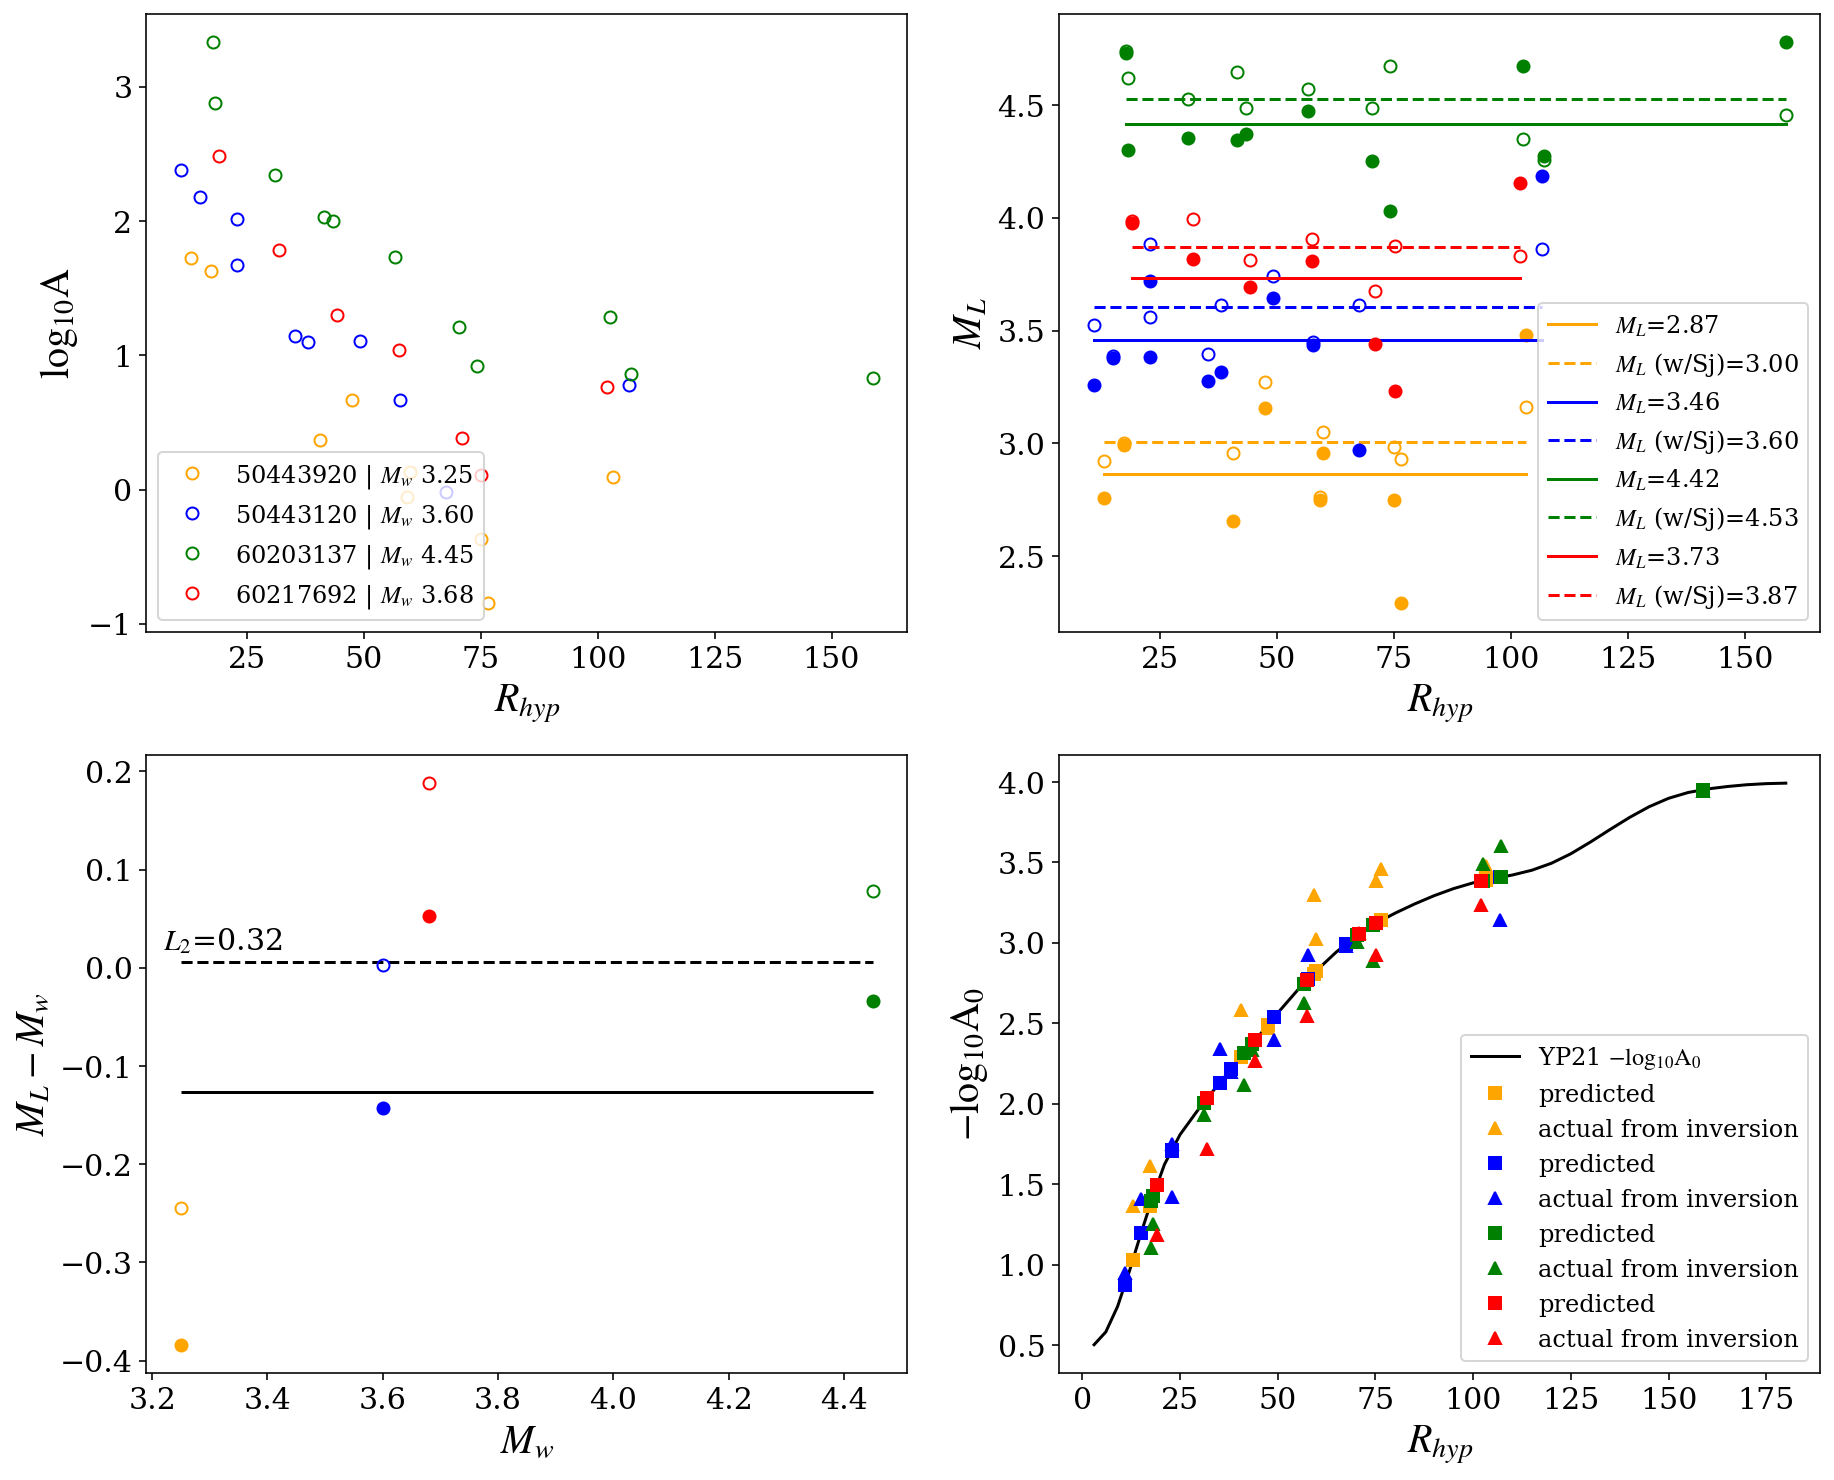

In [21]:
fac = 1.25
nsub = 2
fig, axes = plt.subplots(2, nsub, figsize=(6*nsub*fac, 5*nsub*fac))
axes=axes.flatten()

axes[3].plot(R, -logA0, 'k', label=r"YP21 $\mathrm{-log_{10}A_0}$")  
cols = ['orange', 'blue', 'green', 'red']

MLs = []; MLs_sta = [];
for i, evid in enumerate(evids):
    axes[0].plot(
        Rhyps[i], 
        np.log10(As[i]), 
        'o', 
        mfc='none', 
        color=cols[i], 
        label=f"{str(evid)} | {r'$M_w$'} {mws[i]:.2f}"
    )
    
    axes[3].plot(
        Rhyps[i], 
        -logA0s[i], 
        's',
        color=cols[i],
        label='predicted',
    )
    
    axes[3].plot(
        Rhyps[i],
        -(np.log10(As[i])+Stacs[i]-mws[i]),
        '^',
        color=cols[i],
        label='actual from inversion'
    )
    
    axes[1].plot(Rhyps[i], np.log10(As[i])-logA0s[i], 'o', color=cols[i])
    axes[1].plot(Rhyps[i], np.log10(As[i])-logA0s[i]+Stacs[i], 'o', mfc='none', color=cols[i])
    mean = (np.log10(As[i]) - logA0s[i]).mean()
    means = (np.log10(As[i]) - logA0s[i] + Stacs[i]).mean()
    axes[1].plot(Rhyps[i], [mean for _ in Rhyps[i]], '-', color=cols[i], label=f"{r'$M_L$'}={mean:.2f}")
    axes[1].plot(Rhyps[i], [means for _ in Rhyps[i]], '--', color=cols[i], label=f"{r'$M_L$ (w/Sj)'}={means:.2f}")
    MLs.append(mean)
    MLs_sta.append(means)

    axes[2].plot(mws[i], MLs[i]-mws[i], 'o', color=cols[i])
    axes[2].plot(mws[i], MLs_sta[i]-mws[i], 'o', color=cols[i], mfc='none')
    
axes[2].hlines(
    np.mean(np.array(MLs) - mws), 
    mws.min(), 
    mws.max(), 
    color='k'
)
axes[2].hlines(
    np.mean(np.array(MLs_sta) - mws), 
    mws.min(), 
    mws.max(), 
    color='k', 
    linestyles='dashed'
)
axes[2].text(0.1, 0.7, 
             f"{r'$L_2$'}={np.linalg.norm(np.array(MLs_sta) - mws, 2):.2f}",
             horizontalalignment='center', 
             verticalalignment='center', 
             transform=axes[2].transAxes
            )

axes[0].legend(loc='lower left')
axes[1].legend()
axes[0].set_xlabel(r"$R_{hyp}$")
axes[0].set_ylabel(r"$\mathrm{log_{10}A}$")
axes[1].set_xlabel(r"$R_{hyp}$")
axes[1].set_ylabel(r"$M_L$")
axes[2].set_xlabel(r"$M_w$")
axes[2].set_ylabel(r"$M_{L} - M_{w}$")
axes[3].set_ylabel(r"$\mathrm{-log_{10}A_0}$")
axes[3].set_xlabel(r"$R_{hyp}$")
axes[3].legend()

fig.savefig("../figures/INV-DISAGREEMENT-EXPLAN.pdf")